# Reinforcement Learning

<img src="https://paramitamohamad.files.wordpress.com/2014/03/stivers-2-10-03-pavlovs-dogs-1.gif" style="width: 520px;">

<h5 align="center">Image courtesy of <a href="http://www.uxmatters.com/" target="_blank">UX matters</a></h5>

Let's take a look at an example. You know the game of **Pong**, right? If you don't take a look at this:

<img src="http://bavatuesdays.com/files/2012/02/1pong.gif" style="width: 520px;">

You can even try to play against "AI" created by [Oakly Hall](http://blog.flowstate.io/) here: http://blog.flowstate.io/react-pong/

Now you got the gist of it, right? You just have to make sure that the ball passes behind your opponent's paddle more often than yours.

But that AI is hard to beat (at least for me - it really is!). Can we create another one (preferably better) to kick his a\**? Let's give Reinforcement Learning (RL) a try!

**Reinforcement Learning** can be viewed as part of AI/Machine Learning that tries to maximize future reward $R$ given the current state $S$ of an environment and a set of possible actions $A$. The entity that chooses the next action is typically called an **Agent** (Agents are not bad, right?).

<img src="https://webdocs.cs.ualberta.ca/~sutton/book/ebook/figtmp7.png" style="width: 520px;">

<h5 align="center">Image courtesy of <a href="https://webdocs.cs.ualberta.ca/~sutton/book/ebook/the-book.html" target="_blank">Sutton & Barto book</a></h5>

Concretely, when playing **Pong** you can choose 1 of 3 actions at any time: Up, Down and Do Nothing. Rewards are simple too: positive reward if you score, negative reward if your opponent scores and neutral in any other case (you might get picky here and you will be somewhat right - if you are just about to score, your reward shouldn't be neutral). The state of the environment is determined by your paddle, that of the opponent and the position of the ball.

Okay, we've got a framework in which to represent the game. Are we ready to write some code? Not yet! We need to learn how to play!

# Pumping Iron (Ready for the Gym?)

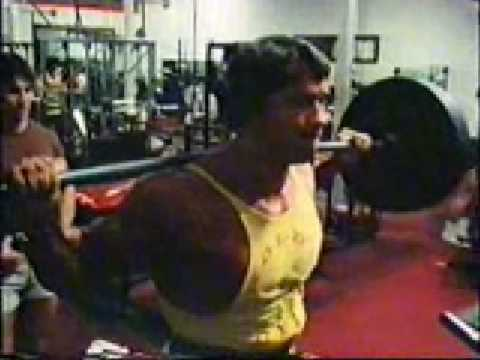

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo("A6SJf1TcMks", width=640, height=480)

First of we need a place to "play" the game of Pong. [Gym](https://gym.openai.com/), created by [OpenAI](https://openai.com/), is a toolkit for developing and evaluating Reinforcement Learning algorithms. Think of it as a playground for RL experiments.

Luckily for us, **Gym** provides an interface for many Atari 2600 games, including Pong. Let's learn to use it, shall we?

Following closely the diagram above, Gym provides an environment for various RL tasks. One can easily retrieve the previous observation (state) and reward given an environment. Using those an action can be chosen to change its state and obtain the reward:

`observation, reward, done, info = environment.step(action)`

Concretely, in the game of Pong, an observation is a screenshot of the screen and the reward is the score obtained after choosing an action.

# Preparing for a workout

Let's setup the the environment. Take a look of the lib versions at the time of writing this:

In [2]:
%load_ext watermark
%watermark -v -m -p numpy,theano,tensorflow,keras,gym

CPython 3.5.1
IPython 5.1.0

numpy 1.11.1
theano 0.8.2
tensorflow 0.10.0
keras 1.0.8
gym 0.2.11

compiler   : GCC 4.2.1 Compatible Apple LLVM 7.0.2 (clang-700.1.81)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


and the setup

In [3]:
import numpy as np
from PIL import Image
import gym

import warnings

warnings.filterwarnings('ignore')

random_state = 42
np.random.seed(random_state);

**Gym** returns the full RGB screen with a width of 210 px and height of 160 px when taking a step in the environment. That means we have input of size $n = 210 * 160 * 3 = 100800$. That a bit too big, right? Let's downsample it to $n = 80 * 80 * 3 = 19200$.

In [4]:
def downsample(observation, new_shape=(80, 80)):
    """ Go from 210x160x3 to 80x80x3 (by default) 3D float vector """
    img = Image.fromarray(observation)
    img = img.resize(new_shape)
    processed_observation = np.array(img)
    return processed_observation.astype(np.float) / 255

# Becoming a Player

Now, our agent will use Deep Q-Network (DQN) to learn how to play Pong. The details of how exactly is done will be available in following posts. For now, let's just look at some code. We will use Keras and Theano. Here's how our agent looks like:

In [5]:
from keras.models import Model
from keras.layers import Convolution2D, Dense, Flatten, Input
from keras.optimizers import RMSprop
from keras import backend as K
from theano.gradient import disconnected_grad

class DQNAgent:
    def __init__(self, state_size=None, number_of_actions=1,
                 epsilon=0.1, minibatch_size=32, discount=0.9, memory=50):
        self.state_size = state_size
        self.number_of_actions = number_of_actions
        self.epsilon = epsilon
        self.minibatch_size = minibatch_size
        self.discount = discount
        self.memory = memory
        self.states = []
        self.actions = []
        self.rewards = []
        self.experience = []
        self.i = 1
        self.build_functions()

    def build_model(self):
        S = Input(shape=self.state_size)
        h = Convolution2D(16, 8, 8, subsample=(4, 4),
            border_mode='same', activation='relu',
            dim_ordering='tf')(S)
        h = Convolution2D(32, 4, 4, subsample=(2, 2),
            border_mode='same', activation='relu',
            dim_ordering='tf')(h)
        h = Flatten()(h)
        h = Dense(256, activation='relu')(h)
        V = Dense(self.number_of_actions)(h)
        self.model = Model(S, V)

    def build_functions(self):
        states = Input(shape=self.state_size)
        next_states = Input(shape=self.state_size)
        actions = Input(shape=(1,), dtype='int32')
        rewards = Input(shape=(1,), dtype='float32')
        transitions = Input(shape=(1,), dtype='int32')
        self.build_model()
        self.value_fn = K.function([states], self.model(states))

        states_values = self.model(states)
        next_states_value = disconnected_grad(self.model(next_states))
        future_value = (1-transitions) * next_states_value.max(axis=1, keepdims=True)
        discounted_future_value = self.discount * future_value
        target = rewards + discounted_future_value
        cost = ((states_values[:, actions] - target)**2).mean()
        opt = RMSprop(0.0001)
        params = self.model.trainable_weights
        updates = opt.get_updates(params, [], cost)
        self.train_fn = K.function([states, next_states, actions, rewards, transitions], cost, updates=updates)

    def new_episode(self):
        self.states.append([])
        self.actions.append([])
        self.rewards.append([])
        self.states = self.states[-self.memory:]
        self.actions = self.actions[-self.memory:]
        self.rewards = self.rewards[-self.memory:]
        self.i += 1

    def end_episode(self):
        pass

    def act(self, state):
        self.states[-1].append(state)
        values = self.value_fn([state[None, :]])
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.number_of_actions)
        else:
            action = values.argmax()
        self.actions[-1].append(action)
        return action, values

    def observe(self, reward):
        self.rewards[-1].append(reward)
        return self._iterate()

    def _iterate(self):
        state_count = len(self.states)
        states = np.zeros((self.minibatch_size,) + self.state_size)
        next_states = np.zeros((self.minibatch_size,) + self.state_size)
        actions = np.zeros((self.minibatch_size, 1), dtype=np.int32)
        rewards = np.zeros((self.minibatch_size, 1), dtype=np.float32)
        transitions = np.zeros((self.minibatch_size, 1), dtype=np.int32)
        for i in range(self.minibatch_size):
            if state_count == 1:
                episode = 0
            else:
                episode = np.random.randint(max(0, state_count-50), state_count-1)
            num_frames = len(self.states[episode])
            if num_frames == 1:
                frame = 0
            else:
                frame = np.random.randint(0, num_frames-1)
            states[i] = self.states[episode][frame]
            transitions[i] = 1 if frame == num_frames - 1 else 0
            if frame < num_frames - 1:
                next_states[i] = self.states[episode][frame+1]
            actions[i] = self.actions[episode][frame]
            rewards[i] = self.rewards[episode][frame]
        cost = self.train_fn([states, next_states, actions, rewards, transitions])
        return cost

Using Theano backend.


Main point of interest in our agent might be the `build_model` method. Our model is a Neural Network (NN) defined similarly to Deep Mind's [Human-level control through Deep Reinforcement Learning](https://deepmind.com/research/dqn/) paper. We essentially have 2 convolutional layers with RELU activation functions, 1 dense layer and 1 output layer which maps to the possible actions. Our NN expects it's input as an 80x80x3 tensor. 

Our DQN agent needs to know the following for successful learning:

* the shape of our screen/input

In [6]:
INPUT_SHAPE = (80, 80)

* valid actions

In [7]:
ACTIONS = [1, # Do nothing
           2, # Up
           3  # Down
          ]

* number of games/episodes to play

In [8]:
num_episodes = 10

Now, let's create the **Gym** environment in which our agent will learn - the game of Pong. Why not seed it properly for easy result reproduction?

In [9]:
env_name = 'Pong-v0'

env = gym.make(env_name)
env.seed(random_state);

[2016-09-19 18:03:47,504] Making new env: Pong-v0


And here is how our agent is created:

In [10]:
agent = DQNAgent(state_size=INPUT_SHAPE + (3,), number_of_actions=len(ACTIONS))

# Finally - The Training

Our agent has a simple interface. We call the `new_episode` method when a new game is started. Then `act` is called at each step/frame of the game. We collect the reward from the environment provided by **Gym** and call `observe` on our agent for learning. We record the total reward obtained during the episode. This continues until all episodes are played.

In [11]:
for _ in range(num_episodes):
    observation = env.reset()
    done = False
    agent.new_episode()
    total_cost = 0.0
    total_reward = 0.0
    frame = 0
    while not done:
        frame += 1
#         env.render()
        action, values = agent.act(downsample(observation))
        observation, reward, done, info = env.step(action + 1)
        total_cost += agent.observe(reward)
        total_reward += reward
    agent.end_episode()
    print("total reward", total_reward)
    print("mean cost", total_cost/frame)

total reward -20.0
mean cost 0.0129376851944
total reward -21.0
mean cost 0.0149919423992
total reward -21.0
mean cost 0.0174246365408
total reward -21.0
mean cost 0.0179952360538
total reward -21.0
mean cost 0.0183682173439
total reward -21.0
mean cost 0.0178977580843
total reward -21.0
mean cost 0.0173074210411
total reward -20.0
mean cost 0.0174804769989
total reward -21.0
mean cost 0.0170642916445
total reward -21.0
mean cost 0.0173520318394


After 10 episodes of training our agent did not seem to improve. Will training for longer (6+ hours) be beneficial?